# THE CORRELATOR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jackknife import Jackknife
from spectral_density import *
from corr_fits import *

plt.style.use('my_style.mplstyle')

In [2]:
#READING THE FULL CORRELATOR
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

dat = df.readlines()

corr_jack = []

for line in dat:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack

corr_full, err_corr_full, cov_corr_full = Jackknife.to_lists(corr_jack)
        
df.close()
jf.close()

## Plot of the correlator, the exponential fit and the difference

Here we would like to sum up the information that the data give us. We plot the correlator, the fit with the double exponential and the difference between the data and the fit, which represents the remainder of the correlator, without the first two states.

To compute the difference, we need to propagate the errors from the original points to the extrapolated ones, so we need the covariance between the original points and the parameters of the fit. Using the formulae in the reference 2209.14188 (Bruno M., Sommer R.), it can be written as:
$$ \mathrm{Cov}_\mathrm{p, d}^{\alpha, t} = [H^{-1}W^2]^{\alpha, r}\,\mathrm{Cov}_\mathrm{d}^{r, t}, $$
where $r$ is in the region of fit, and the sum over $r$ is understood. Now, if $J^{\alpha, t}$ is the jacobian of the model with respect to the parameters, we can compute the covariance between the extrapolated points and the original ones as $\mathrm{Cov}_\mathrm{e, d} = J^T \mathrm{Cov}_\mathrm{p, d} $. The covariance between the points of the difference is then:
$$ \mathrm{Cov}_\mathrm{\Delta} = \mathrm{Cov}_\mathrm{d} + \mathrm{Cov}_\mathrm{e} -2\mathrm{Cov}_\mathrm{e, d}. $$

In [3]:
#READING PARAMETERS OF THE FITS
df = open("out/vector/data/fits/direct_fit_double.txt")
em = open("out/vector/data/fits/eff_mass_fit_full.txt")

t = []
m_df = []
m_df_err = []
m_em = []
m_em_err = []

for l in em.readlines():
    t.append(float(l.split()[0]))
    m_em.append(float(l.split()[1]))
    m_em_err.append(float(l.split()[2]))
    l = df.readline()
    if float(l.split()[0]) == 8:
        C0 = float(l.split()[1])
        m0 = float(l.split()[3])
        err_m0 = float(l.split()[4])
        C1 = float(l.split()[5])
        m1 = float(l.split()[7])
    m_df.append(float(l.split()[3]))
    m_df_err.append(float(l.split()[4]))

df.close()
em.close()

par = [C0, m0, C1, m1]
cov = np.zeros((len(par), len(par)))
cov_file = open("out/vector/data/fits/cov.txt", "r")
for i in range(len(par)):
    for j in range(len(par)):
        line = cov_file.readline()
        cov[i, j] = float(line)

In [4]:
#COMPUTATION OF THE EXTRAPOLATION AND THE REMAINDER
d = Double_exp_np()
corr_fit = np.zeros(len(corr_full))
diff_m = np.zeros(len(corr_full))
for i in range(len(corr_full)):
    corr_fit[i] = d.f(i, par)
    diff_m[i] = float(corr_full[i] - corr_fit[i])

J = np.zeros((len(par), len(corr_full)))
for i in range(len(corr_full)):
    J[:, i] = np.array(d.jac(i, par).tolist(), dtype = float).reshape((4,))

cov_corr_fit = (J.T @ cov @ J)
err_corr_fit = np.sqrt(np.diagonal(cov_corr_fit))

cf = Corr_fits(d.f, d.der_list(), par, np.arange(8, 41), corr_full[8:41], cov_corr_full[8:41, 8:41])
Cpd = cf.cov_par_data(cov_corr_full[8:41, :])
cov_or_fit = J.T @ Cpd

diff_cov = (cov_corr_full + cov_corr_fit - 2 * cov_or_fit)
diff_err = np.sqrt(np.diagonal(diff_cov))

Text(0.5, 1.0, 'The correlator, the fit and the difference')

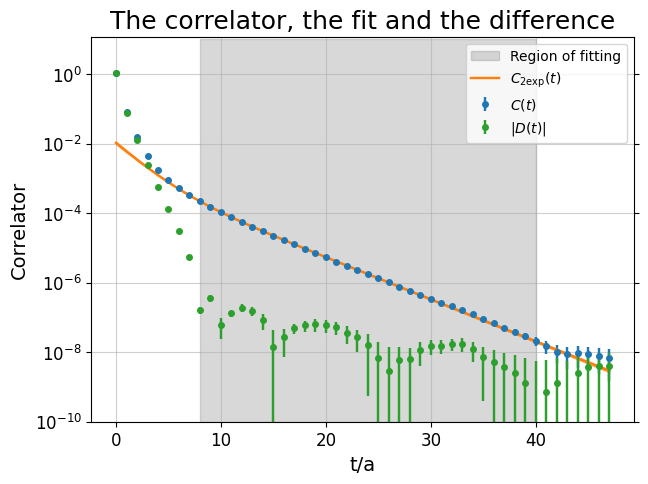

In [10]:
#PLOT PLAIN CORRELATOR, DOUBLE EXPONENTIAL AND PARAMETER
x_grid = range(len(corr_full))

plt.fill_between([8, 40], [10, 10], [1e-10, 1e-10], color="grey", alpha = 0.3, label="Region of fitting")

plt.errorbar(x_grid, corr_full, np.sqrt(np.diagonal(cov_corr_full)), fmt="o", markersize=4, label=r"$C(t)$")

line, = plt.plot(x_grid, corr_fit, label=r"$C_\mathrm{2exp}(t)$")
plt.fill_between(x_grid, corr_fit - err_corr_fit, corr_fit + err_corr_fit, color = line.get_color(), alpha = 0.5)

plt.errorbar(range(len(diff_m)), np.abs(diff_m), diff_err, fmt = "o", markersize = 4, label = r"$|D(t)|$")

plt.semilogy()
plt.legend(loc = "upper right")
plt.ylim(1e-10, 12)
plt.xlabel(r"t/a")
plt.ylabel(r"Correlator")
plt.title("The correlator, the fit and the difference")

### The same, using jackknife

In [35]:
#COMPUTATION OF THE EXTRAPOLATION AND DIFFERENCE USING JACKKNIFE
d = Double_exp_np()

par_jack = Jackknife.fit(d.fit_f, np.arange(8, 41), corr_jack[8:41], [0.02, 0.2, 0.02, 0.5])

diff_jack = []
double_jack = []
for i in range(len(corr_full)):
    f = lambda x: d.f(i, x)
    double_jack.append(Jackknife.der_function(f, par_jack))
    diff_jack.append(corr_jack[i] - Jackknife.der_function(f, par_jack))

diff_jack = diff_jack
diff_m, diff_err, diff_cov = Jackknife.to_lists(diff_jack)
corr_fit, err_corr_fit, cov_corr_fit = Jackknife.to_lists(double_jack)

Text(0.5, 1.0, 'Best fit')

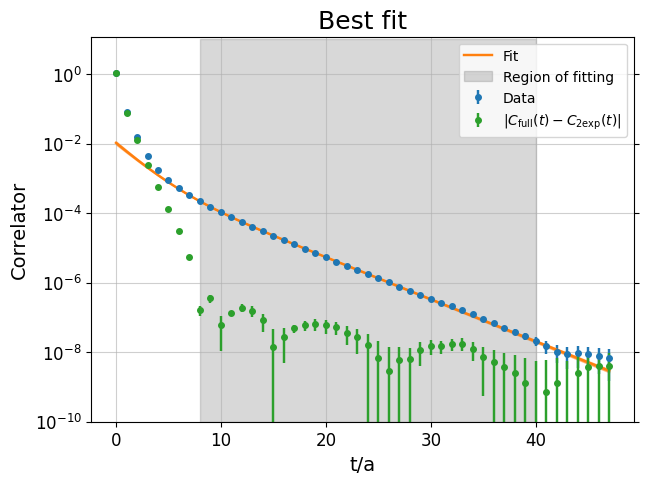

In [36]:
#PLOT PLAIN CORRELATOR, DOUBLE EXPONENTIAL AND PARAMETER
x_grid = range(len(corr_full))
plt.errorbar(x_grid, corr_full, np.sqrt(np.diagonal(cov_corr_full)), fmt="o", markersize=4, label="Data")

line, = plt.plot(x_grid, corr_fit, label="Fit")
plt.fill_between(x_grid, corr_fit - err_corr_fit, corr_fit + err_corr_fit, color = line.get_color(), alpha = 0.5)

plt.fill_between([8, 40], [10, 10], [1e-10, 1e-10], color="grey", alpha = 0.3, label="Region of fitting")

plt.errorbar(range(len(diff_m)), np.abs(diff_m), diff_err, fmt = "o", markersize = 4, label = r"$|C_\mathrm{full}(t) - C_\mathrm{2exp}(t)|$")
plt.semilogy()
plt.legend(loc = "upper right")
plt.ylim(1e-10, 12)
plt.xlabel(r"t/a")
plt.ylabel(r"Correlator")
plt.title("Best fit")

# Some checks on the fit

In this section we collect some check of the fit, using the fit of the effective mass. To be precise, with the second fit it is possible to compute the masses of the first two states, so we can check if the estimation of the parameters $m0$ and $m1$ are compatible between the two parameters. But first, we begin by plotting the parameter $m0$ on the effective mass, to check qualitatively if the estimation is correct.

/home/diego/university/tesi/Analysis_spectral_densities/jackknife.py:93: RuntimeWarning: invalid value encountered in arccosh
  res.mean = f(av)
/home/diego/university/tesi/Analysis_spectral_densities/jackknife.py:99: RuntimeWarning: invalid value encountered in arccosh
  res.jack = np.append(res.jack, f(v))


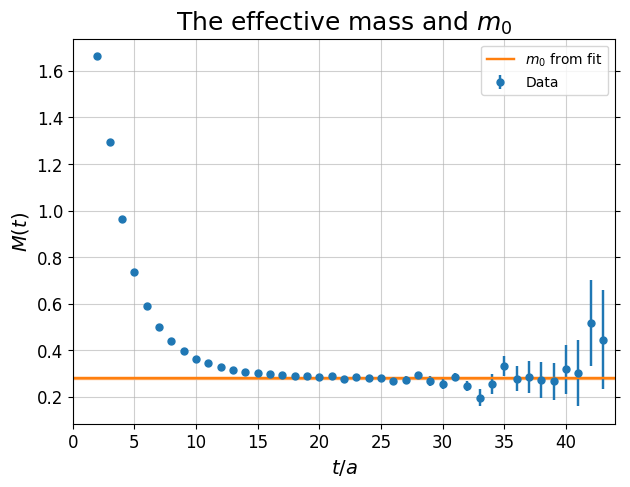

In [11]:
#PLOT OF THE PARAMETER M0 OVER THE EFFECTIVE MASS
em = np.zeros(0)
err_em = np.zeros(0)
em_jack = []
for t in range(2, len(corr_full) - 1):
    em_jack.append(Jackknife.der_function(np.arccosh, [(corr_jack[t + 1] + corr_jack[t - 1])/(corr_jack[t] * 2.0)]))
    em = np.append(em, em_jack[-1].mean)
    err_em = np.append(err_em, np.sqrt(em_jack[-1].variance()))

plt.errorbar(range(2, len(corr_full) - 1), em, err_em, fmt="o", markersize=5, label="Data")
x_grid = np.linspace(0, 48, 50)
line, = plt.plot(x_grid, np.full(50, m0), label = r"$m_0$ from fit")
plt.fill_between(x_grid, np.full(50, m0-err_m0), np.full(50, m0+err_m0), alpha = 0.5, color = line.get_color())
plt.xlim(0.0, 44)
plt.xlabel(r"$t/a$")
plt.ylabel(r"$M(t)$")
plt.title(r"The effective mass and $m_0$")
plt.legend()

Text(0.5, 1.0, 'Difference of $m_0$ estimated with direct fit and effective mass')

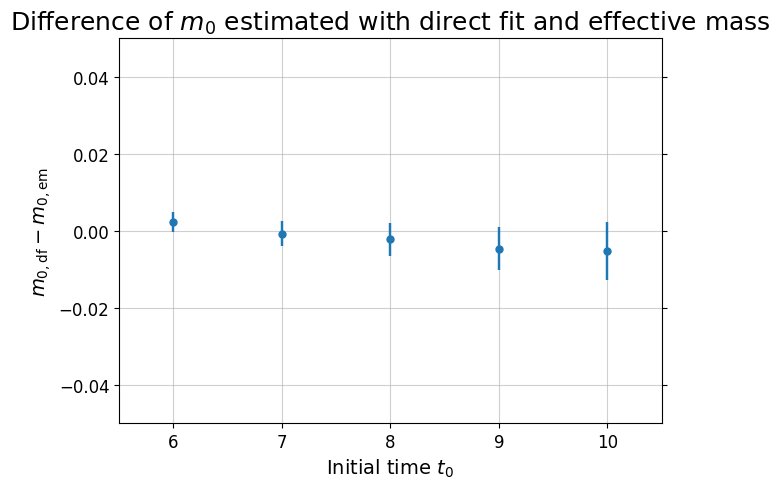

In [30]:
#CHECK OF THE COMPATIBILITY WITH ZERO OF THE PARAMETER M0 ESTIMATED USING DIFFERENT FITS
#CHECK IF CORRECT!!
plt.errorbar(range(len(m_df)), np.array(m_df) - np.array(m_em), np.sqrt(np.array(m_df_err)**2.0 +np.array(m_df_err)**2.0), fmt="o", markersize = 5)
plt.xlim(5.5, 10.5)
plt.ylim(-0.05, 0.05)
plt.xlabel(r"Initial time $t_0$")
plt.ylabel(r"$m_{0, \mathrm{df}} - m_{0, \mathrm{em}}$")
plt.title(r"Difference of $m_0$ estimated with direct fit and effective mass")

Text(0.5, 1.0, 'Difference of $m_0$ estimated with direct fit and effective mass')

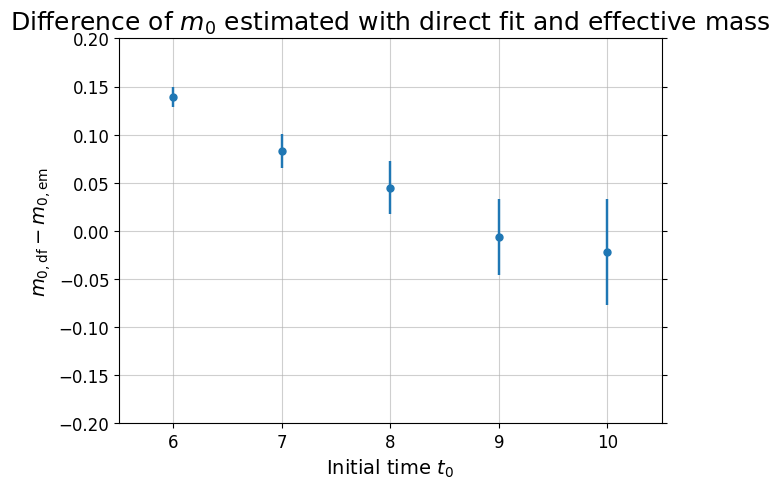

In [23]:
df = open("out/vector/data/fits/direct_fit_double.txt")
em = open("out/vector/data/fits/eff_mass_fit_full.txt")

t = []
m_df = []
m_df_err = []
m_em = []
m_em_err = []

for l in em.readlines():
    t.append(float(l.split()[0]))
    m_em.append(float(l.split()[3]))
    m_em_err.append(float(l.split()[4]))
    l = df.readline()
    if float(l.split()[0]) == 8:
        C0 = float(l.split()[1])
        m0 = float(l.split()[3])
        err_m0 = float(l.split()[4])
        C1 = float(l.split()[5])
        m1 = float(l.split()[7])
    m_df.append(float(l.split()[7]))
    m_df_err.append(float(l.split()[8]))

df.close()
em.close()

plt.errorbar(range(len(m_df)), np.array(m_df) - np.array(m_em), np.sqrt(np.array(m_df_err)**2.0 +np.array(m_df_err)**2.0), fmt="o", markersize = 5)
plt.xlim(5.5, 10.5)
plt.ylim(-0.2, 0.2)
plt.xlabel(r"Initial time $t_0$")
plt.ylabel(r"$m_{0, \mathrm{df}} - m_{0, \mathrm{em}}$")
plt.title(r"Difference of $m_0$ estimated with direct fit and effective mass")